# Los Angeles - Crime Data Analysis (2020 - Present)

### Imports

In [13]:
import os
import requests
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from tqdm import tqdm
import pandas as pd
import dotenv
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Data Download and Loading

In [2]:
dataset_info_env_path = "dataset_info.env"
DATASET_URL = dotenv.get_key(dataset_info_env_path, "DATASET_URL")
DATASET_DOWNLOAD_URL = dotenv.get_key(dataset_info_env_path, "DATASET_DOWNLOAD_URL")
DATASET_FILENAME = dotenv.get_key(dataset_info_env_path, "DATASET_FILENAME")
DATASET_UPDATE_DATE_XPATH = dotenv.get_key(dataset_info_env_path, "DATASET_UPDATE_DATE_XPATH")
DATASET_UPDATE_DATE = dotenv.get_key(dataset_info_env_path, "DATASET_UPDATE_DATE")

driver = webdriver.Chrome()
driver.get(DATASET_URL)
element = WebDriverWait(driver, 10).until(
    EC.presence_of_element_located((By.XPATH, DATASET_UPDATE_DATE_XPATH))
)
dataset_last_updated_date = element.text
driver.quit()

dataset_download_flag = False
if (dataset_last_updated_date != DATASET_UPDATE_DATE):
    dotenv.set_key(dataset_info_env_path, "DATASET_UPDATE_DATE", dataset_last_updated_date)
    dataset_download_flag = True
if DATASET_FILENAME not in os.listdir("./"):
    dataset_download_flag = True

if dataset_download_flag:
    response = requests.get(DATASET_DOWNLOAD_URL)
    if response.status_code == 200:
        total_size = int(response.headers.get('content-length', 0))
        with tqdm(total=total_size, unit='B', unit_scale=True, desc="Downloading") as pbar:
            with open(DATASET_FILENAME, "wb") as f:
                for chunk in response.iter_content(chunk_size=1024):
                    if chunk:
                        f.write(chunk)
                        pbar.update(len(chunk))
    else:
        print("Failed to download the file.")

Downloading: 204MB [00:00, 416MB/s] 


### Preliminary Inspection

In [3]:
df = pd.read_csv(DATASET_FILENAME)
df.head()

,DR_NO,Date Rptd,DATE OCC,TIME OCC,AREA,AREA NAME,Rpt Dist No,Part 1-2,Crm Cd,Crm Cd Desc,...,Status,Status Desc,Crm Cd 1,Crm Cd 2,Crm Cd 3,Crm Cd 4,LOCATION,Cross Street,LAT,LON
0,10304468,01/08/2020 12:00:00 AM,01/08/2020 12:00:00 AM,2230,3,Southwest,377,2,624,BATTERY - SIMPLE ASSAULT,...,AO,Adult Other,624.0,NaN,NaN,NaN,1100 W 39TH PL,NaN,34.0141,-118.2978
1,190101086,01/02/2020 12:00:00 AM,01/01/2020 12:00:00 AM,330,1,Central,163,2,624,BATTERY - SIMPLE ASSAULT,...,IC,Invest Cont,624.0,NaN,NaN,NaN,700 S HILL ST,NaN,34.0459,-118.2545
2,200110444,04/14/2020 12:00:00 AM,02/13/2020 12:00:00 AM,1200,1,Central,155,2,845,SEX OFFENDER REGISTRANT OUT OF COMPLIANCE,...,AA,Adult Arrest,845.0,NaN,NaN,NaN,200 E 6TH ST,NaN,34.0448,-118.2474
3,191501505,01/01/2020 12:00:00 AM,01/01/2020 12:00:00 AM,1730,15,N Hollywood,1543,2,745,VANDALISM - MISDEAMEANOR ($399 OR UNDER),...,IC,Invest Cont,745.0,998.0,NaN,NaN,5400 CORTEEN PL,NaN,34.1685,-118.4019
4,191921269,01/01/2020 12:00:00 AM,01/01/2020 12:00:00 AM,415,19,Mission,1998,2,740,"VANDALISM - FELONY ($400 & OVER, ALL CHURCH VA...",...,IC,Invest Cont,740.0,NaN,NaN,NaN,14400 TITUS ST,NaN,34.2198,-118.4468


In [4]:
n_samples, n_features = df.shape
print(f"Dataset has {n_samples} samples and {n_features} features.")

df.info()

Dataset has 798242 samples and 28 features.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 798242 entries, 0 to 798241
Data columns (total 28 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   DR_NO           798242 non-null  int64  
 1   Date Rptd       798242 non-null  object 
 2   DATE OCC        798242 non-null  object 
 3   TIME OCC        798242 non-null  int64  
 4   AREA            798242 non-null  int64  
 5   AREA NAME       798242 non-null  object 
 6   Rpt Dist No     798242 non-null  int64  
 7   Part 1-2        798242 non-null  int64  
 8   Crm Cd          798242 non-null  int64  
 9   Crm Cd Desc     798242 non-null  object 
 10  Mocodes         688290 non-null  object 
 11  Vict Age        798242 non-null  int64  
 12  Vict Sex        693589 non-null  object 
 13  Vict Descent    693581 non-null  object 
 14  Premis Cd       798233 non-null  float64
 15  Premis Desc     797770 non-null  object 
 16  Weapon Used 

##### Dataset Description

| #  | Column         | Description |
|----|----------------|----------------|
| 0  | DR_NO          | Report Number |
| 1  | Date Rptd      | Date when the crime was reported |
| 2  | DATE OCC       | Date when the crime occurred |
| 3  | TIME OCC       | Time when the crime occurred |
| 4  | AREA           | Area code of the crime location |
| 5  | AREA NAME      | Name of the are where the crime occurred |
| 6  | Rpt Dist No    | Crime Reporting District Number |
| 7  | Part 1-2       | (Unknown: No information in METADATA) |
| 8  | Crm Cd         | Crime Code |
| 9  | Crm Cd Desc    | Crime Description |
| 10 | Mocodes        | (Unknown: No information in METADATA) |
| 11 | Vict Age       | Victim Age |
| 12 | Vict Sex       | Victim Sex |
| 13 | Vict Descent   | Victim Race (Possibly irrelevant information since it's coded and there's no information on coding format ) |
| 14 | Premis Cd      | Code for premises where the crime occurred |
| 15 | Premis Desc    | Description of the premises where the crime occurred |
| 16 | Weapon Used Cd | Weapon Used in the crime |
| 17 | Weapon Desc    | Weapon Description |
| 18 | Status         | Case Status |
| 19 | Status Desc    | Case Status Description |
| 20 | Crm Cd 1       | Additional Crime Codes |
| 21 | Crm Cd 2       | Additional Crime Codes |
| 22 | Crm Cd 3       | Additional Crime Codes |
| 23 | Crm Cd 4       | Additional Crime Codes |
| 24 | LOCATION       | Exact address of crime location |
| 25 | Cross Street   | Name of the cross street |
| 26 | LAT            | Latitiude |
| 27 | LON            | Longitude |

##### Observations

1. Columns like `Date Rptd` and `DATE OCC` are of type `object` i.e., they're in string format. Ideally, they should be changed to date-time format for ease.
2. There are columns with missing values (e.g. `Weapon Used Cd`, `Weapon Used`, `Crm Cd 2` etc.), which needs to be handled during data cleaning.
3. Dtypes of some columns are shown as float which needs to be inspected because they appear as integers upon observation.

### Data Cleaning

##### Converting string to date-time columns

Firstly, we're going to transform the date-time columns into a more suitable form i.e., the date-time format for ease in analysis later on.

In [5]:
df['Date Rptd'] = pd.to_datetime(df['Date Rptd'])
df['DATE OCC'] = pd.to_datetime(df['DATE OCC'])

#Check the format
df.dtypes[['Date Rptd', 'DATE OCC']]

Date Rptd    datetime64[ns]
DATE OCC     datetime64[ns]
dtype: object

##### Handling Missing Values

Now, we'll identify columns having missing values and decide the appropriate course of action for handling them

In [6]:
missing_values_count = df.isnull().sum()
missing_values_columns = missing_values_count[missing_values_count > 0]
missing_values_columns

Mocodes           109952
Vict Sex          104653
Vict Descent      104661
Premis Cd              9
Premis Desc          472
Weapon Used Cd    520347
Weapon Desc       520347
Crm Cd 1              10
Crm Cd 2          739420
Crm Cd 3          796282
Crm Cd 4          798185
Cross Street      670386
dtype: int64

Strategy:

1. **Drop or Impute**: For columns with a small number of missing values, we can either drop the rows or impute the missing values. In our case, such columns are `Premis Cd`, `Premis Desc` and `Crm Cd 1`. Since these features are descriptive in nature, imputation wouldn't make sense. Therefore, we'll drop them.

2. **Keep As-Is or Create Flag**: For columns with a large number of missing values, like `Weapon Used Cd` and `Weapon Desc`, we could leave them as-is or create a flag feature indicating that the data is missing. For our present purposes, we'll leave them as-is.

3. **Drop Columns**: For columns with overwhelmingly missing values (e.g., `Crm Cd 3`, `Crm Cd 4`), we should consider dropping the columns.

In [7]:
#Handling Columns with small number of missing values

initial_shape  = df.shape
df.dropna(subset=['Premis Cd', 'Premis Desc', 'Crm Cd 1'], inplace=True)
final_shape = df.shape

print(f'Dataset Shape before dropping the rows: {initial_shape}')
print(f'Dataset Shape after dropping the rows: {final_shape}')
print(f'Number of Samples Removed: {initial_shape[0] - final_shape[0]}')

Dataset Shape before dropping the rows: (798242, 28)
Dataset Shape after dropping the rows: (797760, 28)
Number of Samples Removed: 482


Before dropping the rows, the dataset had 798242 rows. After removing the rows with missing values in the specified columns, the dataset now has 797760 rows i.e., we've removed 482 rows.

In [8]:
#Handling Columns with overwhelming number of missing values
columns_to_be_dropped = ["Crm Cd 2", "Crm Cd 3", "Crm Cd 4", "Cross Street", "Weapon Used Cd", "Weapon Desc"]

initial_shape  = df.shape
df.drop(columns=columns_to_be_dropped, inplace=True)
final_shape = df.shape

print(f'Dataset Shape before dropping the rows: {initial_shape}')
print(f'Dataset Shape after dropping the rows: {final_shape}')

Dataset Shape before dropping the rows: (797760, 28)
Dataset Shape after dropping the rows: (797760, 22)


We've dropped 6 columns from the original dataset since they have an overwhelming number of missing values.

##### Data-Type Conversion

The following columns: `Crm Cd 1` and `Premis Cd`, contain integer data that is stored in the float format in the dataset. We'll convert such columns to integers for easier analysis.

In [9]:
df['Crm Cd 1'] = df['Crm Cd 1'].astype(int)
df['Premis Cd'] = df['Premis Cd'].astype(int)

df.dtypes[['Crm Cd 1', 'Premis Cd']]

Crm Cd 1     int32
Premis Cd    int32
dtype: object

##### Outlier Detections

Before the Exploratory Data Analysis (EDA) phase, it's considered good practice to look for outliers in the numerical features because they can skew our analyses. Therefore, we'll briefly check the statistics of numerical features for any obvious outliers.

In [10]:
numerical_stats = df.describe()

numerical_stats

,DR_NO,TIME OCC,AREA,Rpt Dist No,Part 1-2,Crm Cd,Vict Age,Premis Cd,Crm Cd 1,LAT,LON
count,7.977600e+05,797760.000000,797760.000000,797760.000000,797760.000000,797760.000000,797760.000000,797760.000000,797760.000000,797760.000000,797760.000000
mean,2.157088e+08,1335.537618,10.715982,1118.023571,1.414430,500.752689,29.866219,305.704777,500.493869,33.976855,-118.018330
std,1.068337e+07,654.023654,6.092853,609.268202,0.492624,207.803842,21.758132,216.619572,207.593175,1.815597,6.295528
min,8.170000e+02,1.000000,1.000000,101.000000,1.000000,110.000000,-3.000000,101.000000,110.000000,0.000000,-118.667600
25%,2.101158e+08,900.000000,6.000000,622.000000,1.000000,331.000000,9.000000,101.000000,331.000000,34.013600,-118.429600
50%,2.121168e+08,1415.000000,11.000000,1142.000000,1.000000,442.000000,31.000000,203.000000,442.000000,34.058400,-118.321500
75%,2.218134e+08,1900.000000,16.000000,1617.000000,2.000000,626.000000,45.000000,501.000000,626.000000,34.163100,-118.273900
max,2.399165e+08,2359.000000,21.000000,2199.000000,2.000000,956.000000,120.000000,971.000000,956.000000,34.334300,0.000000


The descriptive statistics for numerical columns indicate the following:

1. `Vict Age`: The minimum age is -3, which is not possible. The maximum age is 120, which is possible but rare.
2. `LAT` and `LON`: There are coordinates with values of 0, which is likely incorrect for this dataset.

Handling Strategy:

1. For the `Vict Age` feature, we'll replace the negative age values with `NaN`.
2. For the `LAT` and `LON` features, we'll replace the zero values with `NaN`.

In [11]:
df.loc[df['Vict Age'] < 0, 'Vict Age'] = np.nan

df.loc[df['LAT'] == 0, 'LAT'] = np.nan
df.loc[df['LON'] == 0, 'LON'] = np.nan

df[['Vict Age', 'LAT', 'LON']].describe()

,Vict Age,LAT,LON
count,797692.000000,795497.000000,795497.000000
mean,29.868868,34.073511,-118.354064
std,21.757167,0.111153,0.104289
min,0.000000,33.706100,-118.667600
25%,9.000000,34.014500,-118.429900
50%,31.000000,34.058700,-118.322200
75%,45.000000,34.163600,-118.274000
max,120.000000,34.334300,-118.155400


### Exploratory Data Analysis (EDA)

In this stage, we'll focus on different types of analysis steps as follows:

1. **Univariate Analysis**: Analyze singular features to understand their distribution, central tendency and spread.
2. **Bivariate Analysis**: Investigate relationships between pairs of features.
3. **Multivariate Analysis**: Extend the investigation to more than 2 variables to reveal and understand complex relationships.
4. **Visualizations**: Use plots to visualize trends and patterns.

##### Univariate Analysis

We'll begin by examining the distribution of some key variables:

1. **Crime Codes (`Crm Cd`)**: To understand the types of crimes that occur most frequently in Los Angeles.

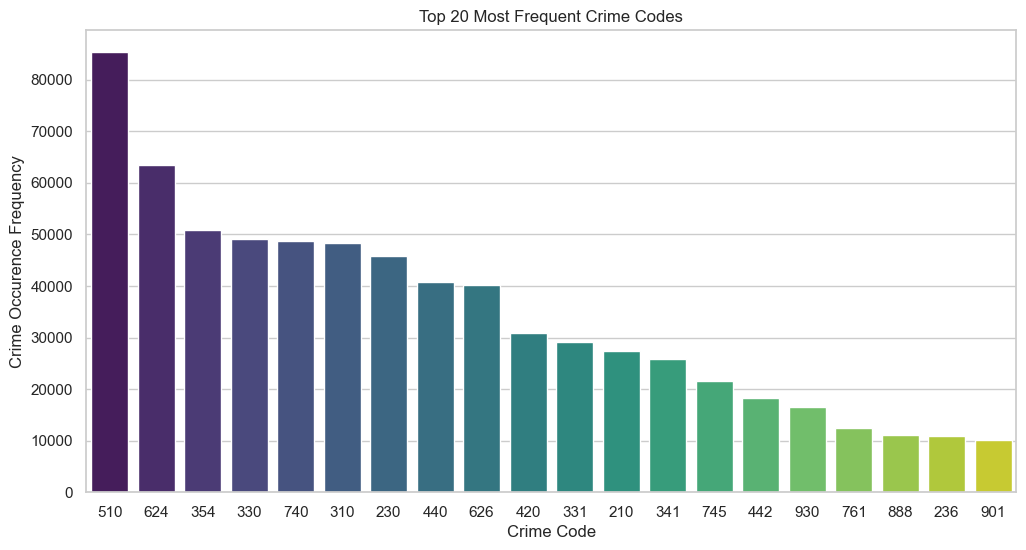

In [42]:
#Crime Codes Visualization
sns.set(style="whitegrid")

plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='Crm Cd', order=df['Crm Cd'].value_counts().iloc[:20].index, palette='viridis')
plt.title('Top 20 Most Frequent Crime Codes')
plt.xlabel('Crime Code')
plt.ylabel('Crime Occurence Frequency')
plt.show()

The above plot displays the top 20 most frequent crime codes in the dataset. Let's associate the crime code to it's associated crime description.

In [39]:
top_20_crime_codes = df['Crm Cd'].value_counts().iloc[:20].index
top_20_crime_codes_desc_df = df[df['Crm Cd'].isin(top_20_crime_codes)][['Crm Cd', 'Crm Cd Desc']]
top_20_crime_codes_desc_df = top_20_crime_codes_desc_df.groupby(['Crm Cd', 'Crm Cd Desc']).size().reset_index(name='Count')
top_20_crime_codes_desc_df = top_20_crime_codes_desc_df.sort_values(by='Count', ascending=False)

,Crm Cd,Crm Cd Desc,Count
11,510,VEHICLE - STOLEN,85321
12,624,BATTERY - SIMPLE ASSAULT,63442
7,354,THEFT OF IDENTITY,50919
4,330,BURGLARY FROM VEHICLE,49043
14,740,"VANDALISM - FELONY ($400 & OVER, ALL CHURCH VA...",48748
3,310,BURGLARY,48314
1,230,"ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT",45904
9,440,THEFT PLAIN - PETTY ($950 & UNDER),40680
13,626,INTIMATE PARTNER - SIMPLE ASSAULT,40257
8,420,THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER),30868


From the above information, we can see that different forms of assault leading to monetary loss and robberies are the most common crimes.

2. **Area Code or Name of the Crime Locations (`AREA` or `AREA NAME`)**: To identify the locations where crimes occur most frequently.

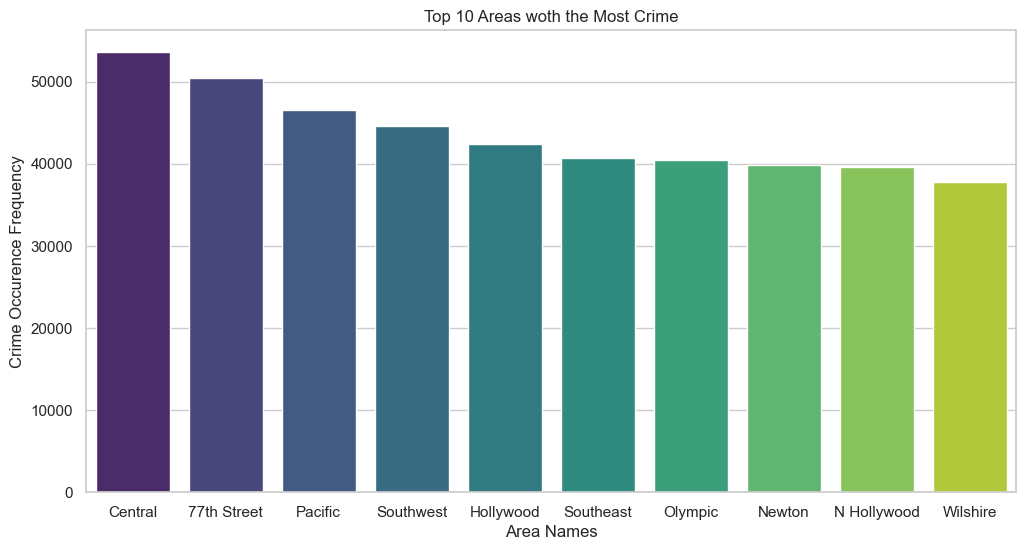

In [44]:
#Crime Location Visualization
sns.set(style="whitegrid")

plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='AREA NAME', order=df['AREA NAME'].value_counts().iloc[:10].index, palette='viridis')
plt.title('Top 10 Areas woth the Most Crime')
plt.xlabel('Area Names')
plt.ylabel('Crime Occurence Frequency')
plt.show()